**Bài 1**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
#transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#Fashion-MNIST
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
# define Generator and Discriminator
class Generator(nn.Module):
      def __init__(self, noise_dim):
          super(Generator, self).__init__()
          self.noise_dim = noise_dim
          self.model = nn.Sequential(
              nn.Linear(noise_dim, 256),
              nn.ReLU(),
              nn.Linear(256,512),
              nn.ReLU(),
              nn.Linear(512, 1024),
              nn.ReLU(),
              nn.Linear(1024, 28*28),
              nn.Tanh()
          )

      def forward(self, x):
          return self.model(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
      def __init__ (self):
          super(Discriminator, self).__init__()
          self.model = nn.Sequential(
              nn.Linear(28*28, 1024),
              nn.LeakyReLU(0.2),
              nn.Linear(1024, 512),
              nn.LeakyReLU(0.2),
              nn.Linear(512, 256),
              nn.LeakyReLU(0.2),
              nn.Linear(256,1),
              nn.Sigmoid()
          )

      def forward(self, x):
          x = x.view(-1, 28*28)
          return self.model(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise_dim = 100


In [ ]:

generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

#loss function and optimizer
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
#create noise
def create_noise(batch_size, noise_dim, device):
    return torch.randn(batch_size, noise_dim, device=device)

In [ ]:
#train model
def train(generator, discriminator, criterion, optimizer_G, optimizer_D, train_loader, device, noise_dim, num_epochs):
    generator.train()
    discriminator.train()
    losses_G = []
    losses_D = []

    for epoch in range(num_epochs):
        loss_D = 0.0
        loss_G = 0.0

        for real_images, _ in train_loader:
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            #label smoothing ( này là làm cho Discriminator học ko quá mạnh, đồng thời cải thiện tính ổn định trong quá trình train "chắc z" )
            real_labels = torch.full((batch_size, 1), 0.9, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            #train Discriminator
            optimizer_D.zero_grad()
            outputs = discriminator(real_images)
            loss_real = criterion(outputs, real_labels)

            noise = create_noise(batch_size, noise_dim, device)
            fake_images = generator(noise)
            outputs = discriminator(fake_images.detach())
            loss_fake = criterion(outputs, fake_labels)

            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizer_D.step()

            #train Generator
            optimizer_G.zero_grad()
            outputs = discriminator(fake_images)
            loss_G = criterion(outputs, real_labels)

            loss_G.backward()
            optimizer_G.step()

            loss_D += loss_D.item()
            loss_G += loss_G.item()

        losses_D.append(loss_D / len(train_loader))
        losses_G.append(loss_G / len(train_loader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss_D: {loss_D.item()}, Loss_G: {loss_G.item()}")

        #visualize
        if (epoch+1) % 10 == 0:
            generator.eval()
            noise = create_noise(16, noise_dim, device)
            fake_images = generator(noise)
            fake_images = fake_images.detach().cpu()
            visualize_images(fake_images)
            generator.train()

    return losses_D, losses_G



In [ ]:
def visualize_images(fake_images, num_images=16, figsize=(5, 5)):
    """
    Hiển thị ảnh giả sinh bởi Generator.

    Args:
        fake_images (Tensor): Batch ảnh sinh ra bởi Generator.
        num_images (int): Số lượng ảnh cần hiển thị.
        figsize (tuple): Kích thước của lưới ảnh.
    """
    # Lấy num_images đầu tiên
    fake_images = fake_images[:num_images]
    fake_images = (fake_images + 1) / 2  # Chuyển giá trị từ [-1, 1] về [0, 1] để hiển thị

    # Tạo lưới ảnh
    plt.figure(figsize=figsize)
    for i in range(num_images):
        plt.subplot(int(num_images**0.5), int(num_images**0.5), i + 1)
        plt.imshow(fake_images[i][0].cpu().numpy(), cmap="gray")  # Lấy kênh đầu tiên (grayscale)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Epoch [1/70], Loss_D: 0.679451584815979, Loss_G: 11.090743064880371
Epoch [2/70], Loss_D: 0.6696089506149292, Loss_G: 13.203971862792969
Epoch [3/70], Loss_D: 0.7129904627799988, Loss_G: 10.333663940429688
Epoch [4/70], Loss_D: 0.8205604553222656, Loss_G: 8.151346206665039
Epoch [5/70], Loss_D: 1.0148214101791382, Loss_G: 8.030914306640625
Epoch [6/70], Loss_D: 1.1876519918441772, Loss_G: 10.471803665161133
Epoch [7/70], Loss_D: 1.1201112270355225, Loss_G: 5.293636322021484
Epoch [8/70], Loss_D: 1.2322640419006348, Loss_G: 5.728065490722656
Epoch [9/70], Loss_D: 1.3142428398132324, Loss_G: 5.500438690185547
Epoch [10/70], Loss_D: 1.645188808441162, Loss_G: 6.852935791015625


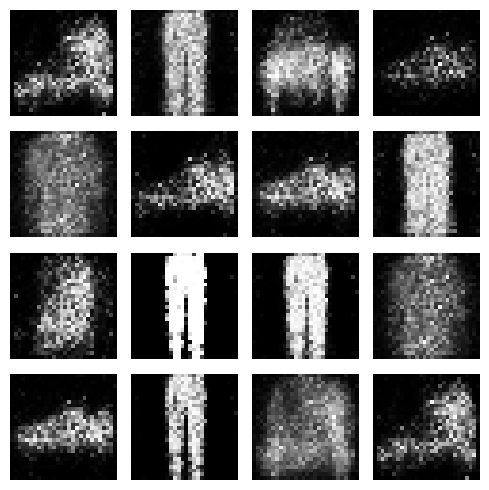

Epoch [11/70], Loss_D: 1.5186406373977661, Loss_G: 15.967823028564453
Epoch [12/70], Loss_D: 1.2684000730514526, Loss_G: 4.131230354309082
Epoch [13/70], Loss_D: 1.8679465055465698, Loss_G: 6.435319423675537
Epoch [14/70], Loss_D: 1.2294540405273438, Loss_G: 6.414948463439941
Epoch [15/70], Loss_D: 1.4848523139953613, Loss_G: 4.932093620300293
Epoch [16/70], Loss_D: 1.526694655418396, Loss_G: 3.7415125370025635
Epoch [17/70], Loss_D: 1.0656651258468628, Loss_G: 5.739798069000244
Epoch [18/70], Loss_D: 1.2813293933868408, Loss_G: 5.2803874015808105
Epoch [19/70], Loss_D: 1.7596900463104248, Loss_G: 4.415700435638428
Epoch [20/70], Loss_D: 1.867141842842102, Loss_G: 4.22610330581665


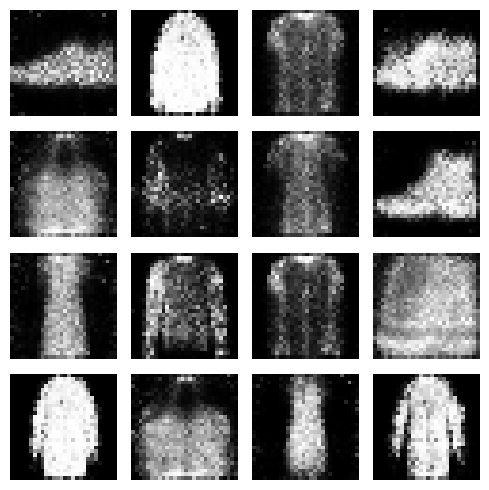

Epoch [21/70], Loss_D: 1.4198992252349854, Loss_G: 4.062570095062256
Epoch [22/70], Loss_D: 1.9415451288223267, Loss_G: 2.7270760536193848
Epoch [23/70], Loss_D: 1.7517826557159424, Loss_G: 4.6006035804748535
Epoch [24/70], Loss_D: 2.1515419483184814, Loss_G: 3.9487051963806152
Epoch [25/70], Loss_D: 1.8516970872879028, Loss_G: 6.484289646148682
Epoch [26/70], Loss_D: 1.9825611114501953, Loss_G: 3.6110644340515137
Epoch [27/70], Loss_D: 1.8387017250061035, Loss_G: 4.014902591705322
Epoch [28/70], Loss_D: 1.5566492080688477, Loss_G: 3.959949016571045
Epoch [29/70], Loss_D: 1.6855990886688232, Loss_G: 3.870274305343628
Epoch [30/70], Loss_D: 1.7716195583343506, Loss_G: 4.117018699645996


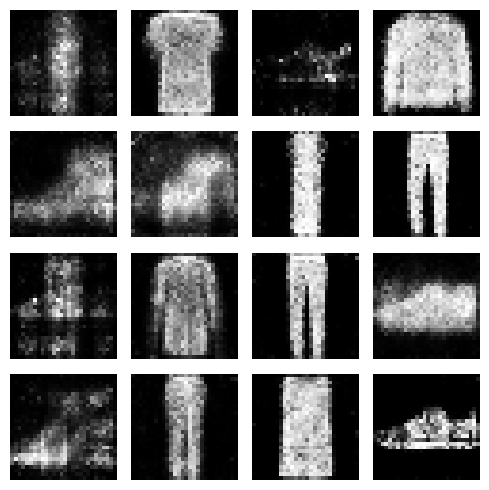

Epoch [31/70], Loss_D: 1.6651209592819214, Loss_G: 3.4607818126678467
Epoch [32/70], Loss_D: 2.3044538497924805, Loss_G: 2.3531851768493652
Epoch [33/70], Loss_D: 1.3792394399642944, Loss_G: 3.918369770050049
Epoch [34/70], Loss_D: 1.7010540962219238, Loss_G: 4.990406036376953
Epoch [35/70], Loss_D: 1.8331035375595093, Loss_G: 3.6681032180786133
Epoch [36/70], Loss_D: 1.8841328620910645, Loss_G: 3.5992610454559326
Epoch [37/70], Loss_D: 1.6212505102157593, Loss_G: 3.706839084625244
Epoch [38/70], Loss_D: 2.0806455612182617, Loss_G: 3.6011362075805664
Epoch [39/70], Loss_D: 1.2421170473098755, Loss_G: 4.701494216918945
Epoch [40/70], Loss_D: 1.8720918893814087, Loss_G: 3.5801150798797607


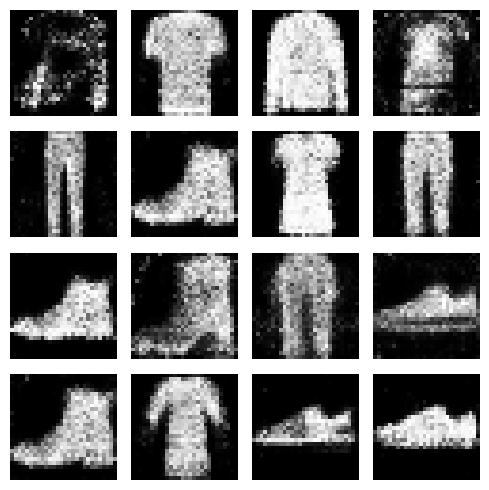

Epoch [41/70], Loss_D: 1.890850305557251, Loss_G: 3.8565516471862793
Epoch [42/70], Loss_D: 2.158351182937622, Loss_G: 4.548491954803467
Epoch [43/70], Loss_D: 1.8390047550201416, Loss_G: 4.006921768188477
Epoch [44/70], Loss_D: 1.707836627960205, Loss_G: 3.6309828758239746
Epoch [45/70], Loss_D: 1.7415013313293457, Loss_G: 4.563176155090332
Epoch [46/70], Loss_D: 1.7878272533416748, Loss_G: 4.011157989501953
Epoch [47/70], Loss_D: 1.959710955619812, Loss_G: 5.02778434753418
Epoch [48/70], Loss_D: 1.6985740661621094, Loss_G: 3.3595845699310303
Epoch [49/70], Loss_D: 2.3118581771850586, Loss_G: 3.332692861557007
Epoch [50/70], Loss_D: 1.8770029544830322, Loss_G: 3.1039671897888184


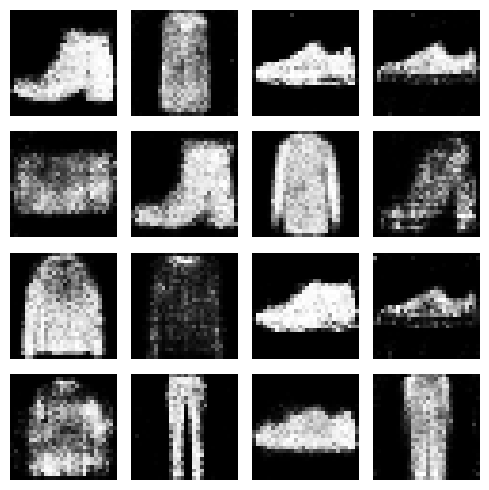

Epoch [51/70], Loss_D: 1.6639999151229858, Loss_G: 3.9635605812072754
Epoch [52/70], Loss_D: 1.8967580795288086, Loss_G: 3.181636095046997
Epoch [53/70], Loss_D: 1.9121187925338745, Loss_G: 3.975825071334839
Epoch [54/70], Loss_D: 2.2215993404388428, Loss_G: 3.105841636657715
Epoch [55/70], Loss_D: 1.901465654373169, Loss_G: 3.074324131011963
Epoch [56/70], Loss_D: 1.8060111999511719, Loss_G: 3.4547858238220215
Epoch [57/70], Loss_D: 1.9494664669036865, Loss_G: 3.5741214752197266
Epoch [58/70], Loss_D: 1.6916581392288208, Loss_G: 3.3117458820343018
Epoch [59/70], Loss_D: 2.0523695945739746, Loss_G: 5.057998180389404
Epoch [60/70], Loss_D: 1.8142741918563843, Loss_G: 3.0858209133148193


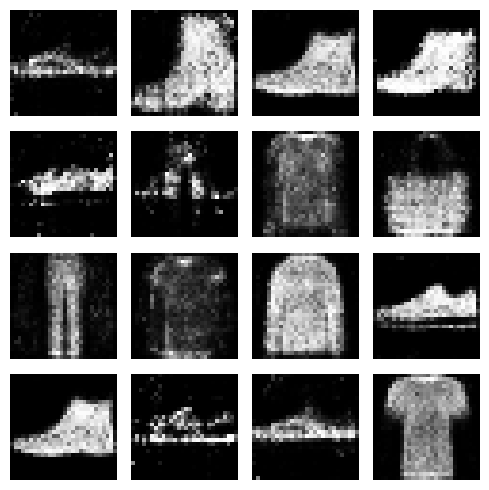

Epoch [61/70], Loss_D: 2.3174080848693848, Loss_G: 2.9822134971618652
Epoch [62/70], Loss_D: 2.2025322914123535, Loss_G: 2.7383365631103516
Epoch [63/70], Loss_D: 1.5501829385757446, Loss_G: 3.5808815956115723
Epoch [64/70], Loss_D: 1.914598822593689, Loss_G: 3.8330183029174805
Epoch [65/70], Loss_D: 2.0610597133636475, Loss_G: 2.9158616065979004
Epoch [66/70], Loss_D: 1.8432899713516235, Loss_G: 4.211620807647705
Epoch [67/70], Loss_D: 1.9860903024673462, Loss_G: 3.5906057357788086
Epoch [68/70], Loss_D: 1.8225295543670654, Loss_G: 3.7682995796203613
Epoch [69/70], Loss_D: 2.6777875423431396, Loss_G: 2.419088840484619
Epoch [70/70], Loss_D: 2.0472092628479004, Loss_G: 3.767601490020752


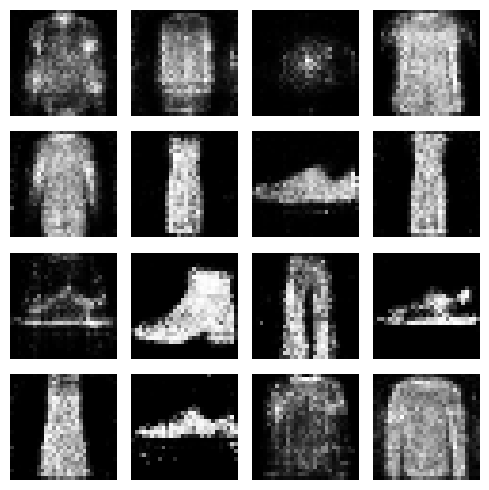

In [ ]:
losses_D, losses_G = train(generator, discriminator, criterion, optimizer_G, optimizer_D, train_loader, device, noise_dim, num_epochs=70)

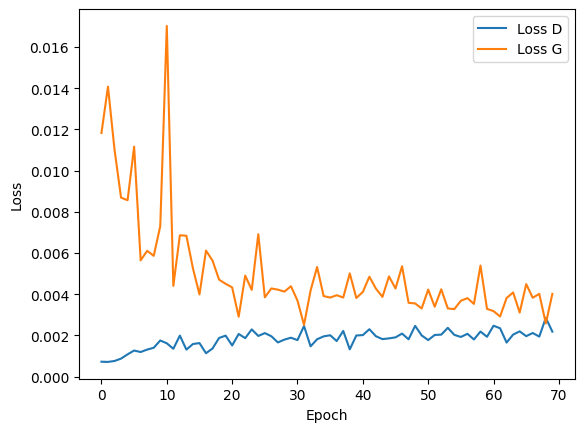

In [ ]:
plt.plot([loss.cpu().detach().numpy() for loss in losses_D], label='Loss D') # Move losses_D to CPU before plotting
plt.plot([loss.cpu().detach().numpy() for loss in losses_G], label='Loss G') # Move losses_G to CPU before plotting
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Bai 2**

bài này em thử cố dùng linear xem kết quả tái tạo ảnh xem kết quả nó thế nào.

In [ ]:
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset2 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform2)
train_loader2 = DataLoader(train_dataset2, batch_size=64, shuffle=True)

100%|██████████| 170M/170M [00:08<00:00, 20.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
class SimpleGenerator(nn.Module):
    def __init__(self, noise_dim, num_classes):
        super(SimpleGenerator, self).__init__()
        self.noise_dim = noise_dim
        self.num_classes = num_classes
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(noise_dim + num_classes, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 32*32*3),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        ''' noise (tensor): random vector, size[batch_size,]
            labels (tensor): label, size = [batch_size]
            return: tensor size=[batch_size, 3, 32, 32] '''
        c = self.label_embedding(labels) # nhung nhan lop
        x = torch.cat((noise, c), dim=1)
        x = self.model(x)
        return x.view(-1, 3, 32, 32)


class SimpleDiscriminator(nn.Module):
    def __init__(self, num_classes):
      """SimpleDiscriminator: phan biet anh that/ anh fake. using labels
      Args:
        num_classes (int): number of classes"""

      super(SimpleDiscriminator, self).__init__()
      self.num_classes = num_classes
      self.label_embedding = nn.Embedding(num_classes, num_classes)
      self.model = nn.Sequential(
          nn.Linear(3*32*32 + num_classes, 512),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Linear(512, 256),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Linear(256, 1),
          nn.Sigmoid()

        )
    def forward(self, x, labels):
        """
        Args:
          x(tensor): anh dau vao, size = [batch_size, 3, 32, 32]
          labels (tensor): label, size = [batch_size]
        Return:
          tensor: real or fake, size = [batch_size, 1]
        """
        c = self.label_embedding(labels)
        x = torch.cat((x.view(x.size(0), -1), c), dim=1)
        return self.model(x)

In [ ]:
noise_dim = 100
num_classes = 10
generator2 = SimpleGenerator(noise_dim, num_classes).to(device)
discriminator2 = SimpleDiscriminator(num_classes).to(device)

In [ ]:
criterion2 = nn.BCELoss()
optimizer_G2 = optim.Adam(generator2.parameters(), lr=0.0002)
optimizer_D2 = optim.Adam(discriminator2.parameters(), lr=0.0002)

In [ ]:
def train_cgan(generator2, discriminator2, criterion2, optimizer_G2, optimizer_D2, train_loader2, noise_dim, num_epochs, device):
    generator2.train()
    discriminator2.train()
    losses_G2 = []
    losses_D2 = []

    for epoch in range(num_epochs):
        epoch_loss_D2 = 0.0
        epoch_loss_G2 = 0.0

        #forward
        for real_images, labels in train_loader2:
            batch_size = real_images.size(0)
            real_images = real_images.view(batch_size, -1).to(device)
            labels = labels.to(device)

            #label smoothing
            real_labels = torch.full((batch_size, 1), 0.9, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            #train discriminator
            optimizer_D2.zero_grad()

            #loss real_images
            outputs = discriminator2(real_images, labels)
            loss_real = criterion2(outputs, real_labels)

            # sinh fake_images
            noise = create_noise(batch_size, noise_dim, device)
            fake_labels_numclass = torch.randint(0, num_classes, (batch_size,), device=device)
            fake_images = generator2(noise, fake_labels_numclass)

            #loss fake_images
            outputs = discriminator2(fake_images.detach(), fake_labels_numclass)
            loss_fake = criterion2(outputs, fake_labels)

            # total loss of discriminator
            loss_D2 = loss_real + loss_fake
            loss_D2.backward()
            optimizer_D2.step()

            #train Generator
            optimizer_G2.zero_grad()

            #scam
            outputs_scam = discriminator2(fake_images, fake_labels_numclass)
            loss_G2 = criterion2(outputs_scam, real_labels)
            loss_G2.backward()
            optimizer_G2.step()

            #plus loss
            epoch_loss_D2 += loss_D2.item()
            epoch_loss_G2 += loss_G2.item()

        losses_D2.append(epoch_loss_D2 / len(train_loader2))
        losses_G2.append(epoch_loss_G2 / len(train_loader2))

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss_D: {loss_D2.item()}, Loss_G: {loss_G2.item()}")

        if (epoch+1) % 10 == 0:
            generator2.eval()
            with torch.no_grad():
                noise = create_noise(16, noise_dim, device)
                labels = torch.randint(0, num_classes, (16,), device=device)
                fake_images = generator2(noise, labels)
                visualize_images2(fake_images, num_images=16)
            generator2.train()

    return losses_D2, losses_G2




In [ ]:
def visualize_images2(images, num_images=16, figsize=(8, 8)):
    if images.is_cuda:
        images = images.cpu()
    images = images[:num_images]
    images = images.view(num_images, 3, 32, 32)
    images = images.permute(0, 2, 3, 1)
    images = (images + 1) / 2

    gird_size = int(num_images ** 0.5)
    fig, axes = plt.subplots(gird_size, gird_size, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i >= len(images):
            break
        img = images[i]
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle('Generated Images')
    plt.show()


Epoch [1/50], Loss_D: 0.4340170919895172, Loss_G: 4.090928554534912
Epoch [2/50], Loss_D: 0.37425586581230164, Loss_G: 5.059437274932861
Epoch [3/50], Loss_D: 0.34876811504364014, Loss_G: 8.25112247467041
Epoch [4/50], Loss_D: 0.3628076910972595, Loss_G: 4.681515693664551
Epoch [5/50], Loss_D: 0.3785770535469055, Loss_G: 5.266855716705322
Epoch [6/50], Loss_D: 0.3456636667251587, Loss_G: 5.260382652282715
Epoch [7/50], Loss_D: 0.8157592415809631, Loss_G: 6.423889636993408
Epoch [8/50], Loss_D: 0.4658292531967163, Loss_G: 3.9785428047180176
Epoch [9/50], Loss_D: 0.5531438589096069, Loss_G: 5.306321144104004
Epoch [10/50], Loss_D: 0.371906578540802, Loss_G: 4.710091590881348


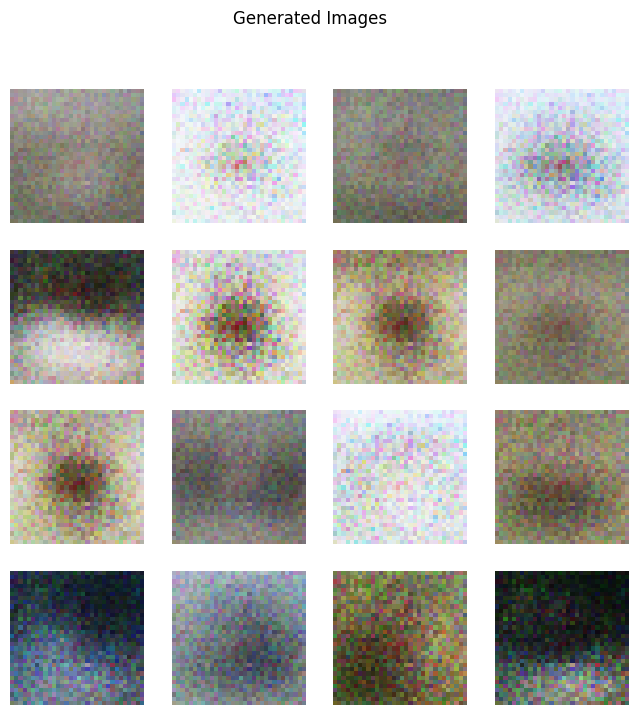

Epoch [11/50], Loss_D: 0.5319721698760986, Loss_G: 3.6445374488830566
Epoch [12/50], Loss_D: 0.548248827457428, Loss_G: 3.4691081047058105
Epoch [13/50], Loss_D: 0.4978194236755371, Loss_G: 3.359485149383545
Epoch [14/50], Loss_D: 0.49003857374191284, Loss_G: 3.8267927169799805
Epoch [15/50], Loss_D: 0.5073398351669312, Loss_G: 3.8803677558898926
Epoch [16/50], Loss_D: 0.5735381841659546, Loss_G: 3.3138253688812256
Epoch [17/50], Loss_D: 0.4359058737754822, Loss_G: 3.6822807788848877
Epoch [18/50], Loss_D: 0.5323939323425293, Loss_G: 3.230553150177002
Epoch [19/50], Loss_D: 0.49812036752700806, Loss_G: 3.151859760284424
Epoch [20/50], Loss_D: 0.4274180829524994, Loss_G: 3.7011237144470215


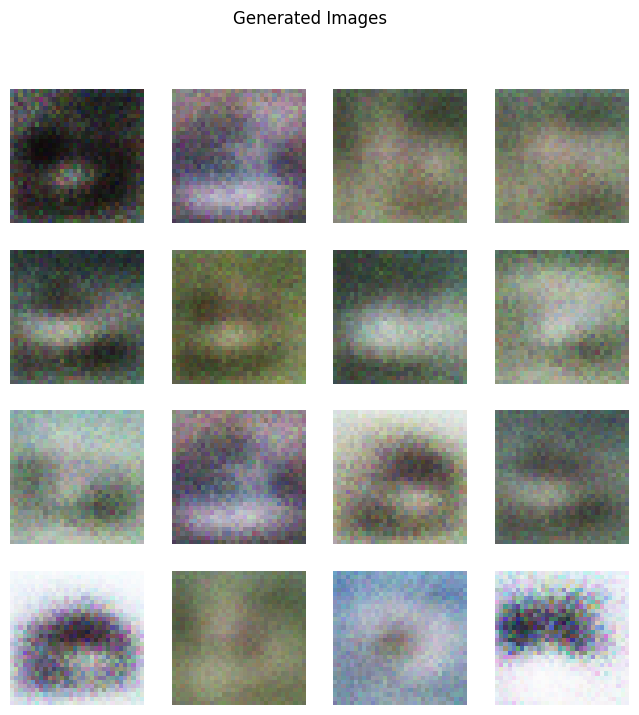

Epoch [21/50], Loss_D: 0.470249205827713, Loss_G: 3.6925415992736816
Epoch [22/50], Loss_D: 0.5534967184066772, Loss_G: 4.401480197906494
Epoch [23/50], Loss_D: 0.6786894202232361, Loss_G: 3.4084672927856445
Epoch [24/50], Loss_D: 0.39151066541671753, Loss_G: 3.943844795227051
Epoch [25/50], Loss_D: 0.525917649269104, Loss_G: 3.643220901489258
Epoch [26/50], Loss_D: 0.5766870379447937, Loss_G: 4.1941118240356445
Epoch [27/50], Loss_D: 0.5746323466300964, Loss_G: 2.909090757369995
Epoch [28/50], Loss_D: 0.5544258952140808, Loss_G: 3.193115711212158
Epoch [29/50], Loss_D: 0.4614839553833008, Loss_G: 4.260920524597168
Epoch [30/50], Loss_D: 0.44733279943466187, Loss_G: 3.5091238021850586


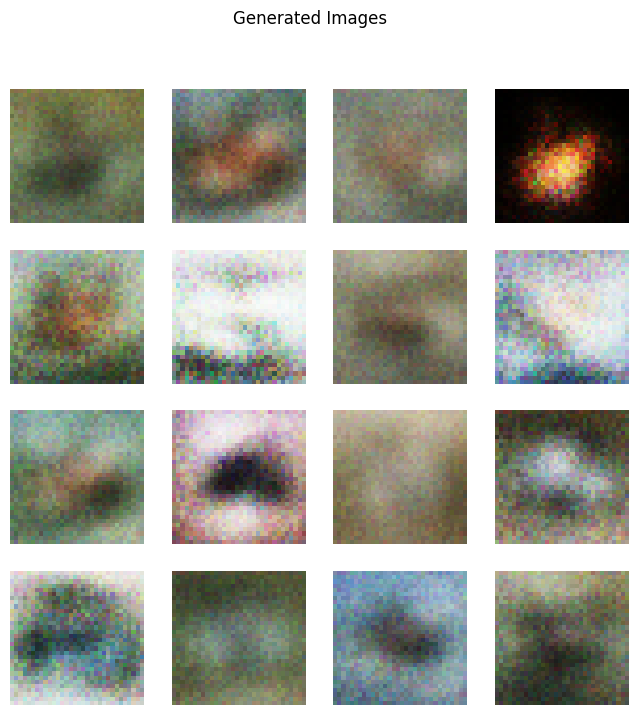

Epoch [31/50], Loss_D: 0.5491039752960205, Loss_G: 3.8304479122161865
Epoch [32/50], Loss_D: 0.5468217730522156, Loss_G: 4.01013708114624
Epoch [33/50], Loss_D: 0.6161761283874512, Loss_G: 3.05936861038208
Epoch [34/50], Loss_D: 0.5185940265655518, Loss_G: 4.28923225402832
Epoch [35/50], Loss_D: 0.5146263837814331, Loss_G: 2.949169397354126
Epoch [36/50], Loss_D: 0.48243433237075806, Loss_G: 3.6871345043182373
Epoch [37/50], Loss_D: 0.6508346796035767, Loss_G: 2.5758557319641113
Epoch [38/50], Loss_D: 0.5589052438735962, Loss_G: 3.835455894470215
Epoch [39/50], Loss_D: 0.4892391860485077, Loss_G: 3.1925292015075684
Epoch [40/50], Loss_D: 0.5115227103233337, Loss_G: 3.806697368621826


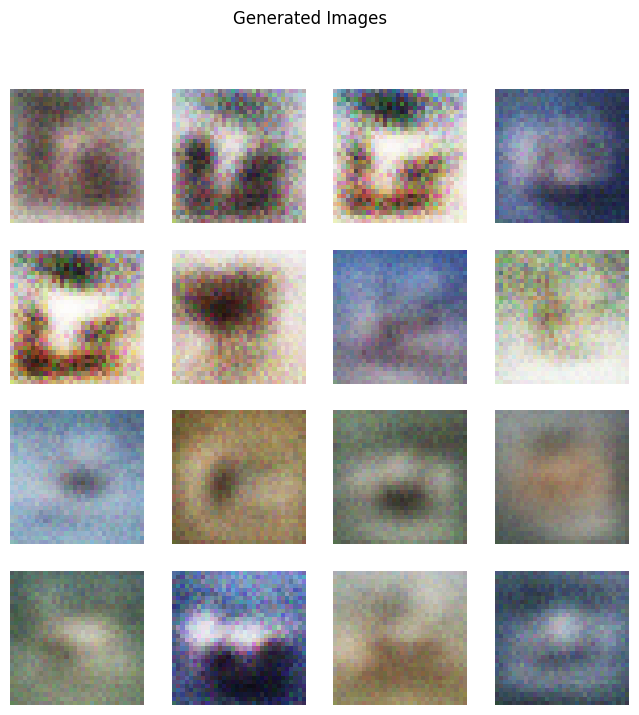

Epoch [41/50], Loss_D: 0.6060932278633118, Loss_G: 2.9585907459259033
Epoch [42/50], Loss_D: 0.7976254224777222, Loss_G: 3.062140941619873
Epoch [43/50], Loss_D: 0.4960675537586212, Loss_G: 3.2784805297851562
Epoch [44/50], Loss_D: 0.4852476716041565, Loss_G: 4.11271858215332
Epoch [45/50], Loss_D: 0.6418278217315674, Loss_G: 2.8476767539978027
Epoch [46/50], Loss_D: 0.6557364463806152, Loss_G: 3.1794610023498535
Epoch [47/50], Loss_D: 0.6424003839492798, Loss_G: 4.567669868469238
Epoch [48/50], Loss_D: 0.43958914279937744, Loss_G: 4.0444488525390625
Epoch [49/50], Loss_D: 0.49086397886276245, Loss_G: 3.024521827697754
Epoch [50/50], Loss_D: 0.5308541059494019, Loss_G: 2.714601993560791


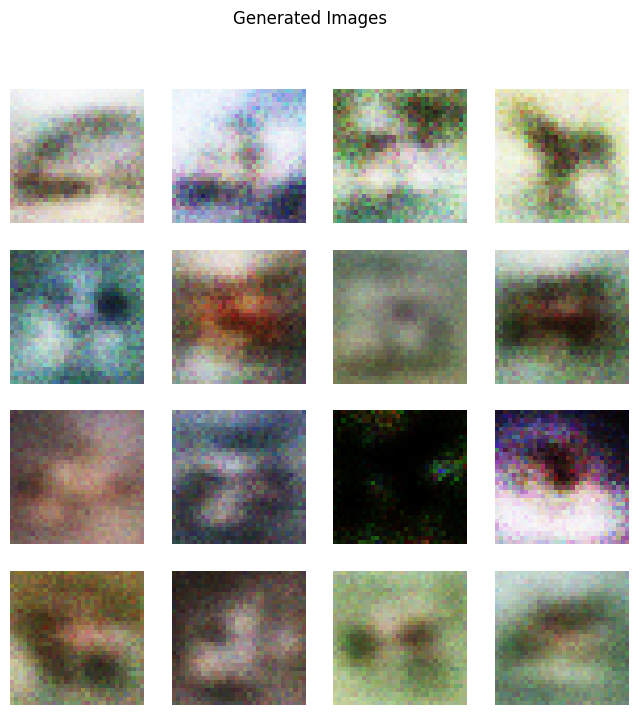

In [ ]:
losses_D2, losses_G2 = train_cgan(generator2, discriminator2, criterion2, optimizer_G2, optimizer_D2, train_loader2, noise_dim, num_epochs=50, device=device)

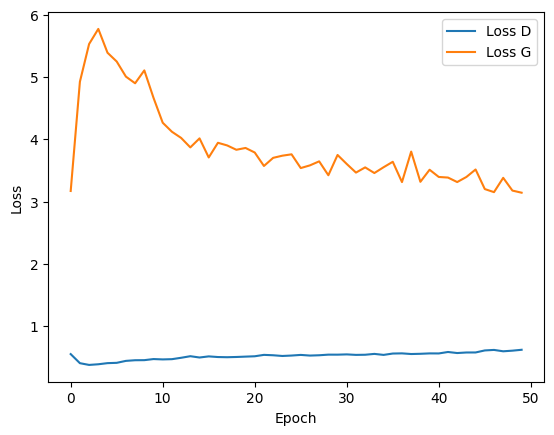

In [ ]:
#visualize loss
plt.plot([loss for loss in losses_D2], label='Loss D')
plt.plot([loss for loss in losses_G2], label='Loss G')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Bai 3**

In [ ]:
#